In [1]:
cd ..

/home/wesg/research/ordinal-probing


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from load import load_model
import datasets
import seaborn as sns
import geopandas as gpd

from feature_datasets.common import *
import utils
import os
from probes.evaluation import *

from probe_experiment import load_probe_results

%matplotlib inline

In [3]:
world_df = load_entity_data('world_place')
us_df = load_entity_data('us_place')
nyc_df = load_entity_data('nyc_place')
art_df = load_entity_data('art')
headline_df = load_entity_data('headline')
figure_df = load_entity_data('historical_figure')

world_shapes = gpd.read_file('data/shapes/WB_countries_Admin0_lowres.geojson')
us_shapes = gpd.read_file('data/shapes/cb_2018_us_state_20m')
nyc_shapes = gpd.read_file('data/shapes/borough_boundaries.geojson')


In [190]:
experiment_name = 'full_prompts'
model_name = 'Llama-2-70b-hf'
feature_name = 'coords'
layer = 40

world_probe_result = load_probe_results(experiment_name, model_name, 'world_place', feature_name, 'coords')
us_probe_result = load_probe_results(experiment_name, model_name, 'us_place', feature_name, 'coords')
nyc_probe_result = load_probe_results(experiment_name, model_name, 'nyc_place', feature_name, 'where_nyc')

art_probe_result = load_probe_results(experiment_name, model_name, 'art', 'release_date', 'release')
headline_probe_result = load_probe_results(experiment_name, model_name, 'headline', 'pub_date', 'when_w_period')
figure_probe_result = load_probe_results(experiment_name, model_name, 'historical_figure', 'death_year', 'when')


In [191]:
from save_activations import load_activation_probing_dataset

world_activations = load_activation_probing_dataset(model_name, 'world_place', 'coords', layer).dequantize()
us_activations = load_activation_probing_dataset(model_name, 'us_place', 'coords', layer).dequantize()
nyc_activations = load_activation_probing_dataset(model_name, 'nyc_place', 'where_nyc_normalized', layer).dequantize()

art_activations = load_activation_probing_dataset(model_name, 'art', 'release', layer).dequantize()
headline_activations = load_activation_probing_dataset(model_name, 'headline', 'article_w_period', layer).dequantize()
figure_activations = load_activation_probing_dataset(model_name, 'historical_figure', 'death_date', layer).dequantize()


In [192]:
world_probe = (world_probe_result['probe_directions'][layer], world_probe_result['probe_biases'][layer])
us_probe = (us_probe_result['probe_directions'][layer], us_probe_result['probe_biases'][layer])
nyc_probe = (nyc_probe_result['probe_directions'][layer], nyc_probe_result['probe_biases'][layer])

art_probe = (art_probe_result['probe_directions'][layer], art_probe_result['probe_biases'][layer])
headline_probe = (headline_probe_result['probe_directions'][layer], headline_probe_result['probe_biases'][layer])
figure_probe = (figure_probe_result['probe_directions'][layer], figure_probe_result['probe_biases'][layer])

In [193]:
result = world_probe_result['projections'][layer][['x', 'y']].values

In [194]:
world_probe

(array([[ 0.002945, -0.002945],
        [-0.000995,  0.005714],
        [ 0.00498 , -0.002161],
        ...,
        [ 0.00651 ,  0.001487],
        [ 0.00208 ,  0.001693],
        [-0.000695, -0.00324 ]], dtype=float16),
 array([-0.23074069,  0.09123324]))

In [195]:
# import spearman
from scipy.stats import spearmanr

world_proj = (np.dot(world_activations.numpy(), world_probe[0].astype(np.float32)) + world_probe[1]) * loc.std(axis=0) + loc.mean(axis=0)
spearmanr(world_proj[:, 1], result[:, 1])

SignificanceResult(statistic=0.9980531435770732, pvalue=0.0)

In [196]:
loc = world_df[['longitude', 'latitude']].values[~world_df.is_test.values]


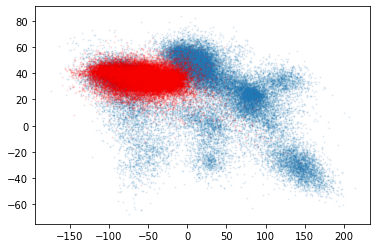

In [204]:
world_proj = (world_activations @ world_probe[0] + world_probe[1]) * loc.std(axis=0) + loc.mean(axis=0)

us_proj = (us_activations @ world_probe[0] + world_probe[1]) * loc.std(axis=0) + loc.mean(axis=0)

plt.scatter(world_proj[:, 0].numpy(), world_proj[:, 1].numpy(), s=1, alpha=0.1)
plt.scatter(us_proj[:, 0].numpy(), us_proj[:, 1].numpy(), s=1, alpha=0.1, color='red')

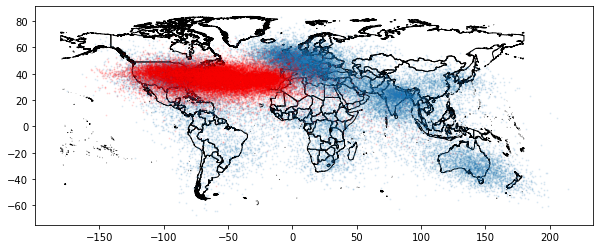

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world_shapes.plot(ax=ax, color='none', edgecolor='black')
ax.scatter(world_proj[:, 0].numpy(), world_proj[:, 1].numpy(), s=1, alpha=0.1)

is_zip = us_df.entity_type == 'zip'
#ax.scatter(us_proj[:, 0].numpy()[is_zip], us_proj[:, 1].numpy()[is_zip], s=1, alpha=0.1, color='red')
ax.scatter(us_proj[:, 0].numpy(), us_proj[:, 1].numpy(), s=1, alpha=0.1, color='red')

In [199]:
loc.mean(axis=0)

array([14.90622031, 26.50586867])

In [200]:
us_df.entity_type.value_counts()

entity_type
city             12904
zip              12533
county            1697
college           1329
structure         1052
natural_place      482
Name: count, dtype: int64

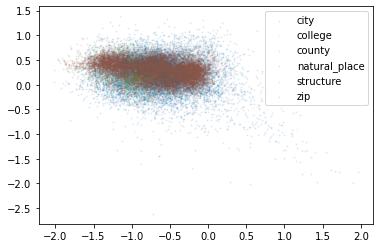

In [201]:
# turn c from string to categorical int
c = us_df.entity_type.values
cint = pd.Categorical(c).codes
# get dict mapping between int and string
cmap = dict(enumerate(pd.Categorical(c).categories))

us_proj = us_activations @ world_probe[0] #+ world_probe[1]
for i in range(6):
    plt.scatter(us_proj[cint==i, 0].numpy(), us_proj[cint==i, 1].numpy(), s=1, alpha=0.1, label=cmap[i])
#plt.scatter(us_proj[:, 0].numpy(), us_proj[:, 1].numpy(), s=1, alpha=0.1, c=cint)

plt.legend()

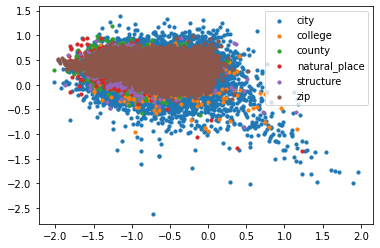

In [202]:
# turn c from string to categorical int
c = us_df.entity_type.values
cint = pd.Categorical(c).codes
# get dict mapping between int and string
cmap = dict(enumerate(pd.Categorical(c).categories))

us_proj = us_activations @ world_probe[0] #+ world_probe[1]
for i in range(6):
    plt.scatter(us_proj[cint==i, 0].numpy(), us_proj[cint==i, 1].numpy(), s=10, alpha=1, label=cmap[i])
#plt.scatter(us_proj[:, 0].numpy(), us_proj[:, 1].numpy(), s=1, alpha=0.1, c=cint)

plt.legend()

In [139]:
# turn categorical into int
cint


array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

In [140]:
cmap

{0: 'city',
 1: 'college',
 2: 'county',
 3: 'natural_place',
 4: 'structure',
 5: 'zip'}

In [141]:
from scipy.stats import spearmanr
entity_corr_dict = {}
for name, group in us_df.groupby('entity_type'):
    entity_corr_dict[name] = {
        'lat': spearmanr(group.latitude.values, us_proj[group.index.values, 1].numpy()).correlation, 
        'lon': spearmanr(group.longitude.values, us_proj[group.index.values, 0].numpy()).correlation
    }

In [142]:
pd.DataFrame(entity_corr_dict)

,city,college,county,natural_place,structure,zip
lat,0.522934,0.493186,0.832148,0.739086,0.561171,0.505870
lon,0.319043,0.336028,0.719178,0.598236,0.514825,0.667819


In [81]:
# probe directions are they orthogonal?
# Are the projections on the other probes correct?

In [82]:
world_probe_result.keys()

dict_keys(['scores', 'projections', 'probe_directions', 'probe_biases', 'probe_alphas'])

In [83]:
world_directions = np.stack(list(world_probe_result['probe_directions'].values()))
us_directions = np.stack(list(us_probe_result['probe_directions'].values()))
nyc_directions = np.stack(list(nyc_probe_result['probe_directions'].values()))

In [84]:
from sklearn.metrics.pairwise import cosine_similarity

world_us_cos_lon = cosine_similarity(world_directions[:, :, 0], us_directions[:, :, 0])
world_us_cos_lat = cosine_similarity(world_directions[:, :, 1], us_directions[:, :, 1])

world_nyc_cos_lon = cosine_similarity(world_directions[:, :, 0], nyc_directions[:, :, 0])
world_nyc_cos_lat = cosine_similarity(world_directions[:, :, 1], nyc_directions[:, :, 1])

us_nyc_cos_lon = cosine_similarity(us_directions[:, :, 0], nyc_directions[:, :, 0])
us_nyc_cos_lat = cosine_similarity(us_directions[:, :, 1], nyc_directions[:, :, 1])

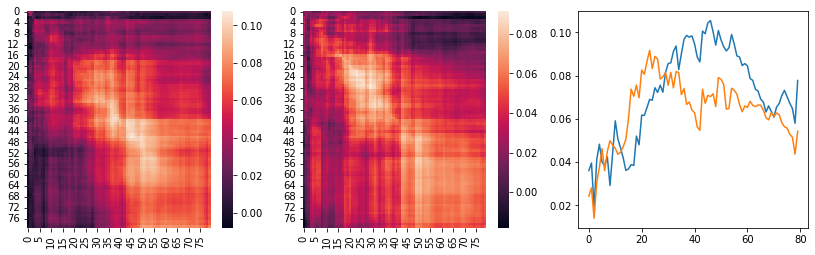

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(world_us_cos_lon, ax=axs[0])
sns.heatmap(world_us_cos_lat, ax=axs[1])
axs[2].plot(np.diag(world_us_cos_lon))
axs[2].plot(np.diag(world_us_cos_lat))

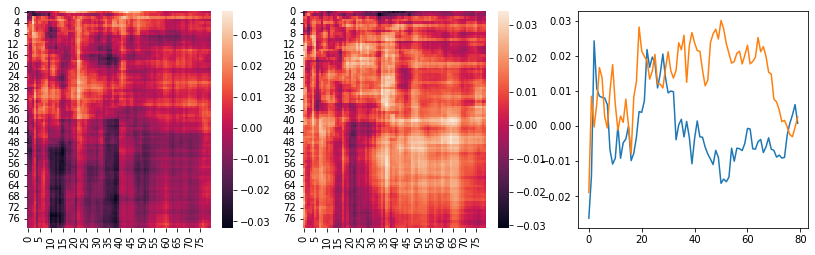

In [86]:
# us and nyc
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(us_nyc_cos_lon, ax=axs[0])
sns.heatmap(us_nyc_cos_lat, ax=axs[1])
axs[2].plot(np.diag(us_nyc_cos_lon))
axs[2].plot(np.diag(us_nyc_cos_lat))


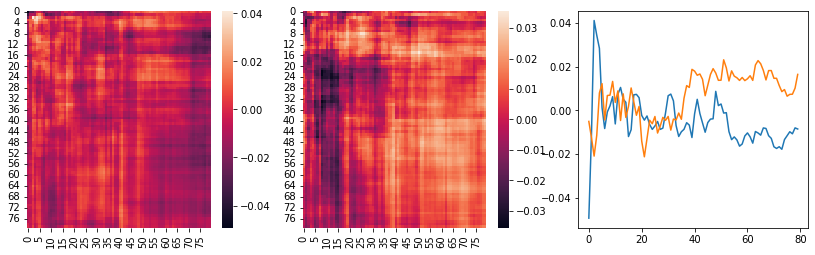

In [87]:
# world and nyc
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(world_nyc_cos_lon, ax=axs[0])
sns.heatmap(world_nyc_cos_lat, ax=axs[1])
axs[2].plot(np.diag(world_nyc_cos_lon))
axs[2].plot(np.diag(world_nyc_cos_lat))

In [28]:
art_directions = np.stack(list(art_probe_result['probe_directions'].values()))
headline_directions = np.stack(list(headline_probe_result['probe_directions'].values()))
figure_directions = np.stack(list(figure_probe_result['probe_directions'].values()))

art_headline_cos = cosine_similarity(art_directions, headline_directions)
art_figure_cos = cosine_similarity(art_directions, figure_directions)
headline_figure_cos = cosine_similarity(headline_directions, figure_directions)


<AxesSubplot:>

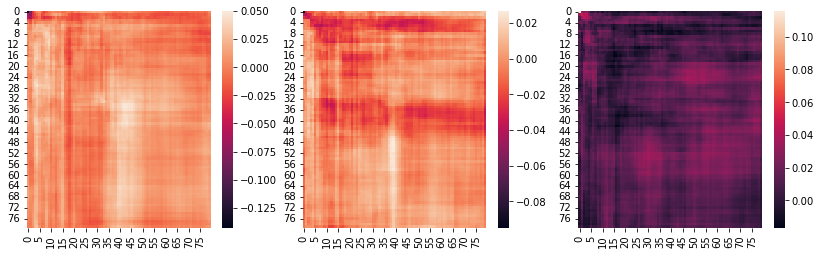

In [30]:
# plot art headline
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(art_headline_cos, ax=axs[0])
sns.heatmap(art_figure_cos, ax=axs[1])
sns.heatmap(headline_figure_cos, ax=axs[2])


Text(0.5, 1.0, 'headline figure')

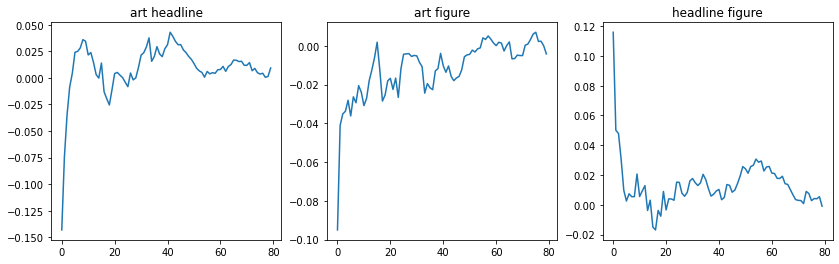

In [32]:
# line plot with all
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].plot(np.diag(art_headline_cos))
axs[1].plot(np.diag(art_figure_cos))
axs[2].plot(np.diag(headline_figure_cos))

# set title
axs[0].set_title('art headline')
axs[1].set_title('art figure')
axs[2].set_title('headline figure')

In [38]:
NS_PER_YEAR = 1e9 * 60 * 60 * 24 * 365.25
art_pred_datetime = pd.to_datetime(art_probe_result['projections'][50].projection * NS_PER_YEAR)
art_true_datetime = pd.to_datetime(art_df.release_date.values)

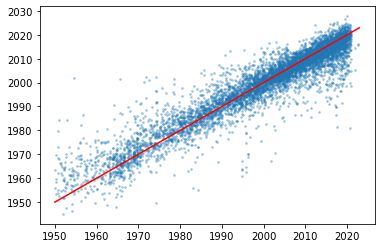

In [23]:
art_is_test = art_df.is_test.values
plt.scatter(art_true_datetime[art_is_test], art_pred_datetime[art_is_test], s=3, alpha=0.3)
# y = x line
plt.plot([art_true_datetime.min(), art_true_datetime.max()], [art_true_datetime.min(), art_true_datetime.max()], color='red')

In [35]:
NS_PER_YEAR = 1e9 * 60 * 60 * 24 * 365.25
headline_pred_datetime = pd.to_datetime(headline_probe_result['projections'][50].projection * NS_PER_YEAR)
headline_true_datetime = pd.to_datetime(headline_df.pub_date.values)

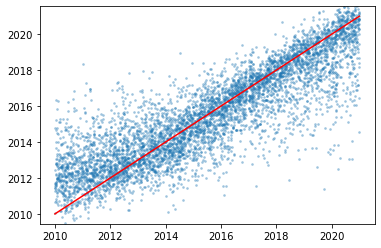

In [36]:
headline_is_test = headline_df.is_test.values
plt.scatter(headline_true_datetime[headline_is_test], headline_pred_datetime[headline_is_test], s=3, alpha=0.3)
# y = x line
plt.plot([headline_true_datetime.min(), headline_true_datetime.max()], [headline_true_datetime.min(), headline_true_datetime.max()], color='red')

In [56]:
2 * ((12 * 3072) ** 2 * 12 * 12) / (2 * 2**30)

182.25

In [45]:
figure_pred_datetime = figure_probe_result['projections'][50].projection
figure_true_datetime = figure_df.death_year.values

(450.0, 2020.0)

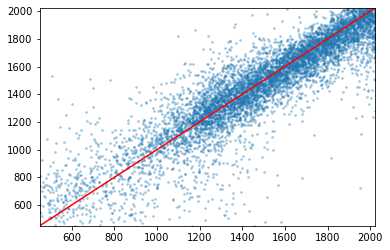

In [52]:
figure_is_test = figure_df.is_test.values
plt.scatter(figure_true_datetime[figure_is_test], figure_pred_datetime[figure_is_test], s=3, alpha=0.3)
# y = x line
plt.plot([figure_true_datetime.min(), figure_true_datetime.max()], [figure_true_datetime.min(), figure_true_datetime.max()], color='red')
plt.ylim(450, 2020)
plt.xlim(450, 2020)


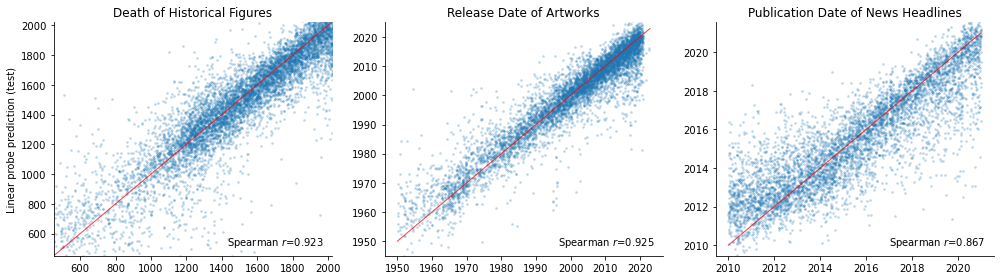

In [29]:
from scipy.stats import spearmanr
from datetime import datetime


fig, axs = plt.subplots(1, 3, figsize=(14, 4))

NS_PER_YEAR = 1e9 * 60 * 60 * 24 * 365.25


# Figure
figure_pred_datetime = figure_probe_result['projections'][50].projection
figure_true_datetime = figure_df.death_year.values
figure_is_test = figure_df.is_test.values

figure_spearman = spearmanr(figure_true_datetime[figure_is_test], figure_pred_datetime[figure_is_test]).correlation

ax = axs[0]
ax.scatter(figure_true_datetime[figure_is_test], figure_pred_datetime[figure_is_test], s=3, alpha=0.2)
ax.plot(
    [figure_true_datetime.min(), figure_true_datetime.max()], 
    [figure_true_datetime.min(), figure_true_datetime.max()], 
    color='red', lw=1, alpha=0.75
)
ax.set_ylim(450, 2020)
ax.set_xlim(450, 2020)
ax.set_title('Death of Historical Figures')
ax.set_ylabel('Linear probe prediction (test)')
ax.annotate(f'Spearman $r$={figure_spearman:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom')

# Art
art_pred_datetime = pd.to_datetime(art_probe_result['projections'][50].projection * NS_PER_YEAR)
art_true_datetime = pd.to_datetime(art_df.release_date.values)
art_is_test = art_df.is_test.values

art_spearman = spearmanr(art_true_datetime[art_is_test], art_pred_datetime[art_is_test]).correlation

ax = axs[1]
ax.scatter(art_true_datetime[art_is_test], art_pred_datetime[art_is_test], s=3, alpha=0.2)
ax.plot(
    [art_true_datetime.min(), art_true_datetime.max()], 
    [art_true_datetime.min(), art_true_datetime.max()], 
    color='red', lw=1, alpha=0.75
)
ax.set_title('Release Date of Artworks')
ax.set_ylim(datetime(1945, 1, 1), datetime(2025, 1, 1))
ax.annotate(f'Spearman $r$={art_spearman:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom')

# Headline
headline_pred_datetime = pd.to_datetime(headline_probe_result['projections'][50].projection * NS_PER_YEAR)
headline_true_datetime = pd.to_datetime(headline_df.pub_date.values)
headline_is_test = headline_df.is_test.values

headline_spearman = spearmanr(headline_true_datetime[headline_is_test], headline_pred_datetime[headline_is_test]).correlation

ax = axs[2]
ax.scatter(headline_true_datetime[headline_is_test], headline_pred_datetime[headline_is_test], s=3, alpha=0.2)
ax.plot(
    [headline_true_datetime.min(), headline_true_datetime.max()], 
    [headline_true_datetime.min(), headline_true_datetime.max()], 
    color='red', lw=1, alpha=0.75
)
ax.set_title('Publication Date of News Headlines')
ax.annotate(f'Spearman $r$={headline_spearman:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/time_scatter_main.png', bbox_inches='tight')


In [18]:
from datetime import datetime
datetime(2025, 1, 1)

datetime.datetime(2025, 1, 1, 0, 0)

In [15]:
# convert numeric year to datetime
def year_to_datetime(year):
    return pd.to_datetime(year, format='y')

In [39]:
from scipy.stats import spearmanr, pearsonr
spearmanr(art_true_datetime[art_is_test].values.astype(np.int64), art_pred_datetime[art_is_test].values.astype(np.int64))

SignificanceResult(statistic=0.9249133059157968, pvalue=0.0)

In [40]:
spearmanr(headline_true_datetime[headline_is_test].values.astype(np.int64), headline_pred_datetime[headline_is_test].values.astype(np.int64))

SignificanceResult(statistic=0.8671244536560532, pvalue=0.0)

In [51]:
spearmanr(figure_true_datetime[figure_is_test], figure_pred_datetime[figure_is_test])

SignificanceResult(statistic=0.9227519110514423, pvalue=0.0)